In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import pydrake
from pydrake.autodiffutils import AutoDiffXd
from pydrake.common.eigen_geometry import Quaternion, AngleAxis, Isometry3
from pydrake.forwarddiff import gradient, jacobian
from pydrake.geometry import (
    Box,
    Sphere
)
from pydrake.multibody.inverse_kinematics import InverseKinematics
from pydrake.multibody.plant import (
    AddMultibodyPlantSceneGraph,
    CoulombFriction,
    MultibodyPlant
)
from pydrake.multibody.tree import (
    JointIndex,
    PrismaticJoint,
    SpatialInertia,
    UniformGravityFieldElement,
    UnitInertia
)
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve
from pydrake.systems.framework import DiagramBuilder

import scene_generation.differentiable_nlp as diff_nlp
import scene_generation.data.dataset_utils as dataset_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of pyro.distributions.gaussian_scale_mixture failed: Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RuntimeError: maximum recursion depth exceeded in __instancecheck__
]
[autoreload of pyro.poutine.handlers failed: Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name util
]
[autoreload of pyro.infer.traceenum_elbo failed: Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: 'module' object has no attribute 'messenger'
]
[autoreload of pyro.distributions.relaxed_

Initial guess:  [ 0.05 -0.05  0.    0.    0.    0.  ]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 0.10499999 -0.10499999  0.          0.          0.          0.        ]


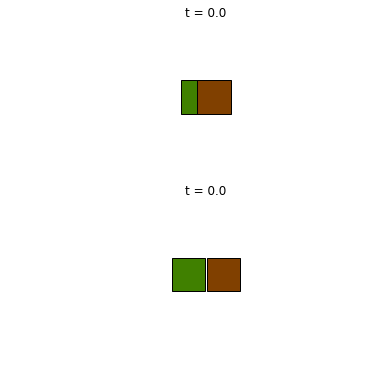

In [55]:
# OLD METHOD
# Simple planar single box
env = {"n_objects": 2,
       "obj_0000": {
           "class": "2d_box",
           "color": [0.5, 0.25, 0.0, 1.0],
           "params": [0.2, 0.2],
           "params_names": ["height", "length"],
           "pose": [0.05, 0., 0.]},
       "obj_0001": {
           "class": "2d_box",
           "color": [0.25, 0.5, 0.0, 1.0],
           "params": [0.2, 0.2],
           "params_names": ["height", "length"],
           "pose": [-0.05, 0., 0.]}
}
builder, mbp, sg, q0 = dataset_utils.BuildMbpAndSgFromYamlEnvironment(
    yaml_environment=env,
    base_environment_type="planar_tabletop")
plt.figure()
plt.subplot(2, 1, 1)
dataset_utils.DrawYamlEnvironmentPlanar(env, base_environment_type="planar_tabletop", ax=plt.gca())
plt.subplot(2, 1, 2)
feas_env = dataset_utils.ProjectEnvironmentToFeasibility(
    env, base_environment_type="planar_tabletop",
    make_nonpenetrating=True, make_static=False)
dataset_utils.DrawYamlEnvironmentPlanar(feas_env[-1], base_environment_type="planar_tabletop", ax=plt.gca())

MBP in final:  <pydrake.multibody.plant.MultibodyPlant object at 0x7f6f88088eb0>
setup done
Initial guess:  [0.      0.10001 0.     ]
Used solver:  SNOPT/f2c
Success?  True
qf:  [0.         0.10999999 0.        ]
Constraint # 0
Val: [9.54739602e-13] (range [[0.], [0.]])
Jac:  [[ 0.         -0.00013818  0.        ]]
Constraint # 1
Val: [0.         0.10999999 0.        ] (range [[-inf -inf -inf], [inf inf inf]])
Jac:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Nullspace:  [[-1.  0.]
 [ 0.  0.]
 [ 0.  1.]]
Constraint viol dirs:  [[-0.          0.00013818 -0.        ]
 [ 0.         -0.00013818  0.        ]]
dqf_dq0:  [[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


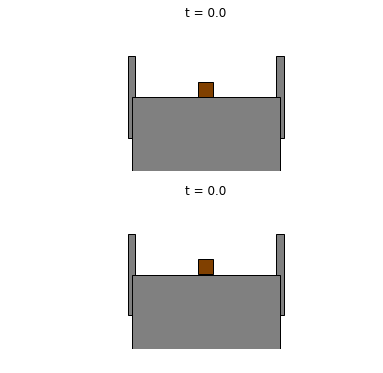

In [57]:
env = {"n_objects": 1,
       "obj_0000": {
           "class": "2d_box",
           "color": [0.5, 0.25, 0.0, 1.0],
           "params": [0.2, 0.2],
           "params_names": ["height", "length"],
           "pose": [0.00, 0.10001, 0.]},
       "obj_0001": {
           "class": "2d_box",
           "color": [0.25, 0.5, 0.0, 1.0],
           "params": [0.2, 0.2],
           "params_names": ["height", "length"],
           "pose": [-0.05, 0., 0.]}
}
builder, mbp, scene_graph, q0 = dataset_utils.BuildMbpAndSgFromYamlEnvironment(
        env, "planar_bin")
diagram = builder.Build()

diagram_context = diagram.CreateDefaultContext()
mbp_context = diagram.GetMutableSubsystemContext(
    mbp, diagram_context)


diff_nlp_res = diff_nlp.ProjectMBPToFeasibility(
    q0, mbp, mbp_context,
    [diff_nlp.SetArguments(
        diff_nlp.AddMinimumDistanceConstraint, minimum_distance=0.01)],
    compute_gradients_at_solution=True,
    verbose=2)

# Update poses in output dict
feas_env = deepcopy(env)
output_qf = diff_nlp_res.qf
for k in range(env["n_objects"]):
    x_index = mbp.GetJointByName(
        "body_{}_x".format(k)).position_start()
    z_index = mbp.GetJointByName(
        "body_{}_z".format(k)).position_start()
    t_index = mbp.GetJointByName(
        "body_{}_theta".format(k)).position_start()

    pose = [output_qf[x_index],
            output_qf[z_index],
            output_qf[t_index]]
    feas_env["obj_%04d" % k]["pose"] = pose
    
plt.figure()
plt.subplot(2, 1, 1)
dataset_utils.DrawYamlEnvironmentPlanar(env, base_environment_type="planar_bin", ax=plt.gca())
plt.subplot(2, 1, 2)
dataset_utils.DrawYamlEnvironmentPlanar(feas_env, base_environment_type="planar_bin", ax=plt.gca())

In [111]:
import torch
env = {"n_objects": 2,
       "obj_0000": {
           "class": "2d_box",
           "color": [0.5, 0.25, 0.0, 1.0],
           "params": [0.2, 0.2],
           "params_names": ["height", "length"],
           "pose": [-0.1, -0.1, 0.]},
       "obj_0001": {
           "class": "2d_box",
           "color": [0.25, 0.5, 0.0, 1.0],
           "params": [0.2, 0.2],
           "params_names": ["height", "length"],
           "pose": [0.1, 0.1, 0.]}
}
builder, mbp, scene_graph, q0 = dataset_utils.BuildMbpAndSgFromYamlEnvironment(
        env, "planar_tabletop")
diagram = builder.Build()

diagram_context = diagram.CreateDefaultContext()
mbp_context = diagram.GetMutableSubsystemContext(
    mbp, diagram_context)

q_tensor = torch.tensor(q0.copy(), requires_grad=True, dtype=torch.float)
qf_desired_tensor = torch.zeros(q0.shape, dtype=torch.float)
qf_desired_tensor[mbp.GetJointByName("body_0_x").position_start()] = 0.25
qf_desired_tensor[mbp.GetJointByName("body_1_x").position_start()] = -0.25

qs = [q0.copy()]
for k in range(201):
    q_proj_tensor = diff_nlp.ProjectMBPToFeasibilityTorch.apply(
        q_tensor, mbp, mbp_context,
        [diff_nlp.SetArguments(diff_nlp.AddMinimumDistanceConstraint, minimum_distance=0.01)],
        0.01, 0)
    loss = (q_proj_tensor - qf_desired_tensor).dot(q_proj_tensor - qf_desired_tensor)
    loss.backward()
    with torch.no_grad():
        q_tensor -= 0.01 * q_tensor.grad
        q_tensor.grad.zero_()
    if (k % 10 == 0):
        print("Loss %d: %f" % (k, loss.item()))
    qs.append(q_proj_tensor.detach().numpy().copy())

[autoreload of scene_generation.differentiable_nlp failed: Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RuntimeError: maximum recursion depth exceeded in __instancecheck__
]


Loss 0: 0.271414
Loss 10: 0.189892
Loss 20: 0.134148
Loss 30: 0.096894
Loss 40: 0.071955
Loss 50: 0.057260
Loss 60: 0.052161
Loss 70: 0.048773
Loss 80: 0.046507
Loss 90: 0.035958
Loss 100: 0.024006
Loss 110: 0.016026
Loss 120: 0.010699
Loss 130: 0.007143
Loss 140: 0.004769
Loss 150: 0.003184
Loss 160: 0.002125
Loss 170: 0.001419
Loss 180: 0.000947
Loss 190: 0.000632
Loss 200: 0.000422


In [112]:
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10, 5))
def animate_update(i):
    # Update poses in output dict
    local_env = deepcopy(env)
    output_qf = qs[i]
    for k in range(env["n_objects"]):
        x_index = mbp.GetJointByName(
            "body_{}_x".format(k)).position_start()
        z_index = mbp.GetJointByName(
            "body_{}_z".format(k)).position_start()
        t_index = mbp.GetJointByName(
            "body_{}_theta".format(k)).position_start()

        pose = [output_qf[x_index],
                output_qf[z_index],
                output_qf[t_index]]
        local_env["obj_%04d" % k]["pose"] = pose
    ax.clear()
    dataset_utils.DrawYamlEnvironmentPlanar(local_env, base_environment_type="planar_tabletop", ax=ax)
    ax.grid(True)
    ax.axis('on')
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(qs),
                              interval=5000/len(qs),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display